# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import os
import cv2

# TODO: fill this in based on where you saved the training and testing data
training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
X_test.dtype

dtype('uint8')

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_test.shape[1:3]

# TODO: how many classes are in the dataset
n_classes = len(list(set(train['labels'])))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [5]:
if sorted(list(y_train)) == list(y_train):
    print("The training data is sorted")
    print(y_train)

The training data is sorted
[ 0  0  0 ..., 42 42 42]


In [6]:
one_hot_encoded = False

In [7]:
y_test[0:20]

array([16,  1, 38, 33, 11, 38, 18, 12, 25, 35, 12,  7, 23,  7,  4,  9, 21,
       20, 27, 38], dtype=uint8)

 The test set is not sorted

In [19]:
# check the distribution of the training data over the test set classes
# the training images are grouped by tracks of 30 images, see
#
# http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
# 
# sanity check that all images come in streams of 30 and count of different tracks per class.
def sanity_check():
    n_seq = 30
    l = list(y_train)
    train_struc=[[x,l.count(x),l.count(x) % n_seq, l.count(x) % n_seq] for x in set(l)]
    faulty_classes = [(faulty_class,rest) for faulty_class,_,rest,_ in train_struc if rest > 0]

    # these are the classes that do not have 30 images in each track
    return faulty_classes

sanity_check()

[(33, 29)]

### Note: _There is a frame missing in class 33. It turns out it is in track 19. This needs to be fixed!_
Plot one representative of each class

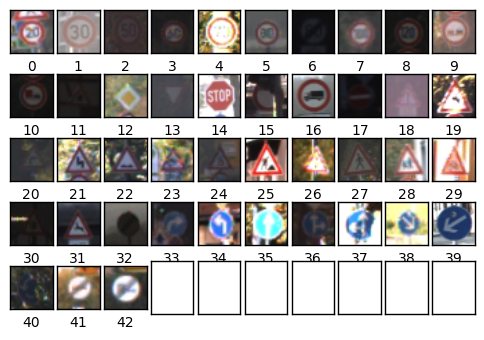

In [20]:
first_indices=[]
for class_num in range(n_classes):
    ind = np.where(y_train==class_num)[0][0]
    first_indices.append(ind)

fig, axes = plt.subplots(5,10)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
    
for i, ax in enumerate(axes.flat):
    if i<n_classes: 
        ax.imshow(X_train[first_indices[i]])
        xlabel = "{0}".format(i)
        ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])    
    

plt.show()

In [21]:
# define a plot function
def plot_images(images, n_imgs, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == n_imgs
    assert not n_imgs % 10
    
    # Create figure with sub-plots.
    
    fig, axes = plt.subplots(n_imgs//10,10)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    
    

    for i, ax in enumerate(axes.flat):
        # Plot image.
        if images.shape[-1]==1: 
            ax.imshow(images[i].reshape(image_shape), cmap='gray')
        else:
            ax.imshow(images[i])

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "{0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

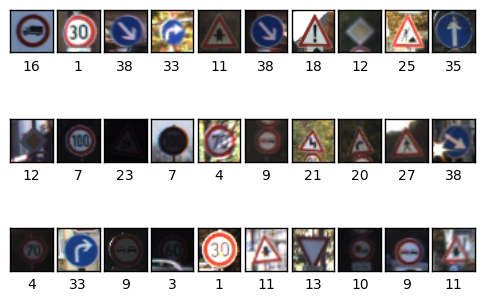

In [22]:
# Get the first images from the test set.
n_imgs =30
images = X_test[0:n_imgs]

# Get the true classes for those images.
cls_true = y_test[0:n_imgs]

# Plot the images and labels using our helper-function above.
plot_images(images=images, n_imgs=n_imgs, cls_true=cls_true)

# Conclusions

1. The classes in the data set are not balanced
2. The quality of the images varies greatly. Quite a few raffic signs are not recognizable with the human eye. 
3. The lighting conditions vary from bright daylight to darkness, foggy conditions, point of view 
4. Some traffic signs are partially obscured.
5. There are not a lot of training examples for all classes
6. _All images are taken from 30 frame video sequences of an approaching camera, except that track 19 of class 33 is missing a frame._



We will have to deal with the uneven lighting conditions, data augmentation and creation of an appropriate validation set, that does not bleed into the training data. For the latter we take the approach discussed in "Traffic Sign Recognition with Multi-Scale Convolutional Networks", http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

We begin by defining a few functions needed for preprocessing

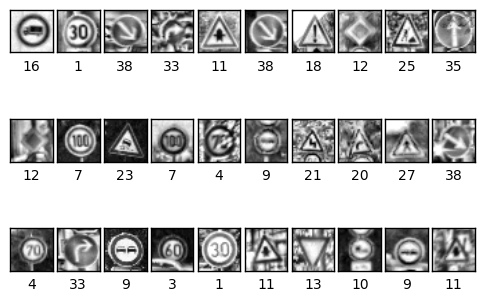

In [27]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    shape = img.shape    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.reshape((shape[0],shape[1],1))
    return img

def applyCLAHE(img):
    """
    Apply local contrast maximization to a single channel uint8 image
    """
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))
    img_clahe = clahe.apply(img)
    return img_clahe

def normalize_grayscale(img):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    a = 0.1;b = 0.9; Xmin = 0.0;Xmax = 255.0;
    X = img;
    Xp = a + (X-Xmin)*(b-a)/(Xmax-Xmin)
    return Xp

# this function will be used to preprocess all images
def preprocess_images(images):    
    shape = images.shape 
    out_img_shape=(shape[1],shape[2],1)
    batch = np.zeros((shape[0],shape[1],shape[2],1))
    
    for i in range(len(images)):        
        img = images[i,:]        
        img = grayscale(img)        
        img = applyCLAHE(img).reshape(out_img_shape)
        img = normalize_grayscale(img)        
        batch[i] = img
    return batch

# plot a few to see the result
images = preprocess_images(X_test[0:n_imgs])
plot_images(images=images, n_imgs=n_imgs, cls_true=cls_true) 

This looks much better. Before we apply the preprocessing function to the whole data set, we augment the data set and then preprocess all images in one go.

In [28]:
# we will do this later 
# X_test  = preprocess_images(X_test)
# X_train = preprocess_images(X_train)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** As can be seen above many images have very little contrast. Global contrast optimization does not help for images that are very dark or very bright all over. THe data set is not very large and traffic signs are designed to have good contrast. Moreover, working with black and white images provided better results in the benchmark  paper "Traffic Sign Recognition with Multi-Scale Convolutional Networks" of the Le Cun group, quoted above. Therefore a preprocessing function was designed that first simply converts all images to grayscale. Subsequently local contrast optimization is applied (CLAHE algorithm), followed by Min-Max normalization which brings the values of all images into the range [0.1, 0.9], as done in the "Finding Lane-Line Project". However, note that a range of [-1:1] would equally have been possible and is actually recommended, see http://www.faqs.org/faqs/ai-faq/neural-nets/part2/. It would be interesting to investigate the effects of different normalization schemes in the future. Particularly, the local contrast optimization greatly helped turning otherwise practically unrecognizable traffic signs into something useful, please compare the sample images above before and after the preprocessing step. 

**Note**
1.  We will apply the image preprocessing function below after the augmentation of the data set 
2.  We will also one-hot encode the class labels only after augmentation of the data set.

These two steps are still to come

In [29]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

#first duplicate the first frame in class 33 track 19, so all tracks have length 30
class_num = 33
track = 19
first_ind = np.where(y_train==class_num)[0][0]
dup = X_train[first_ind+track*n_seq,:]
X_train = np.insert(X_train,first_ind+track*n_seq, dup, 0)
y_train = np.insert(y_train,first_ind+track*n_seq, 33, 0)

l = list(y_train)
train_struc=[[x,l.count(x),l.count(x) % n_seq, l.count(x)/n_seq] for x in set(l)]

#we perform the sanity check once more
sanity_check()

[(33, 1)]

Now every track has 30 frames and we can split into tracks easily

In [30]:
# We create 2 additional data sets by random translations and rotations of the training set

# set the seed for reproducible results
np.random.seed(seed=40)

def random_translation(img,t_range):
    rows,cols,ch = img.shape
    p=10 #pad the image (reflect the boundary)
    tr_x = t_range*np.random.uniform()-t_range/2
    tr_y = t_range*np.random.uniform()-t_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    wrap = cv2.copyMakeBorder(img,p,p,p,p,cv2.BORDER_REFLECT)
    img = cv2.warpAffine(wrap,Trans_M,(cols+2*p,rows+2*p))
    img = img[p:p+cols,p:p+rows]
    return img

def random_rotation(img,ang_range):
    rows,cols,ch = img.shape 
    p=10 #pad the image (reflect the boundary)
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
    wrap = cv2.copyMakeBorder(img,p,p,p,p,cv2.BORDER_REFLECT)
    img = cv2.warpAffine(wrap,Rot_M,(cols+2*p,rows+2*p))
    img = img[p:p+cols,p:p+rows]
    return img

X_trans = np.zeros_like(X_train)
X_rot = np.zeros_like(X_train)

for i in range(len(X_train)):    
    X_trans[i]=random_translation(X_train[i],t_range=4)
    X_rot[i]=random_rotation(X_train[i],ang_range=30)


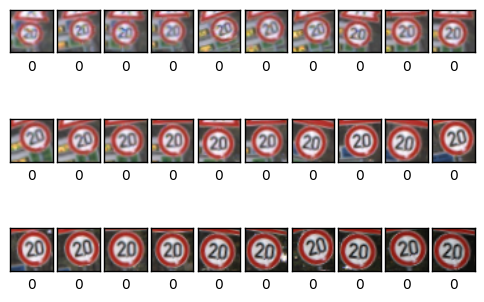

In [31]:
# plot a few of the augmented rotated images
images = X_rot[0:n_imgs]
plot_images(images=images, n_imgs=n_imgs, cls_true=y_train[0:n_imgs]) 

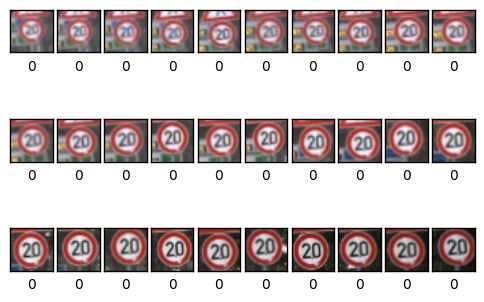

In [32]:
# plot a few of the augmented translated images
images = X_trans[0:n_imgs]
plot_images(images=images, n_imgs=n_imgs, cls_true=y_train[0:n_imgs]) 

In [33]:
X_aug = [X_train, X_rot, X_trans]
X_aug = np.vstack(X_aug)
print('Augmented training set',X_aug.shape)
y_aug = [y_train,y_train,y_train]
y_aug = np.hstack(y_aug)
print('Augmented training labels',y_aug.shape)

Augmented training set (117633, 32, 32, 3)
Augmented training labels (117633,)


In [34]:
# validation set creation: pick randomly entire tracks from the training data.
X_train = X_aug
y_train = y_aug

n_train = y_train.shape[0];
n_tracks = int(n_train/n_seq)

tracks = np.arange(n_tracks)
np.random.shuffle(tracks)

val_frac = 0.2 # split 80/20 in training and validation set
n_val_tracks=int(val_frac*n_tracks)
val_tracks   = tracks[:n_val_tracks]
val_tracks   = list(val_tracks)
train_tracks = list(set(tracks)-set(val_tracks))

val_rows=np.array([np.arange(x*n_seq,(x+1)*n_seq) for x in val_tracks])
val_rows=val_rows.flatten()
y_val=y_train[val_rows]
X_val = X_train[val_rows,:]

train_rows=np.array([row for row in np.arange(n_train) if row not in val_rows])
train_rows=train_rows.flatten()
y_train = y_train[train_rows]
X_train = X_train[train_rows,:]

n_train = len(y_train)
n_val   = len(y_val)

# now preprocess all images
X_train = preprocess_images(X_train)
X_val   = preprocess_images(X_val)
X_test  = preprocess_images(X_test)


# sanity check of data
print('classes in training set', len(set(y_train))) # number of classes in new training set
print('classes in validation set',len(set(y_val)))   # number of classes in validation set
print('classes in test set',len(set(y_test)))   # number of classes in test set

print('Training set',X_train.shape, ', y_train',y_train.shape)
print('Validation set',X_val.shape,', y_val ',y_val.shape)
print('Test set',X_test.shape,', y_test ',y_test.shape)


classes in training set 43
classes in validation set 43
classes in test set 43
Training set (94113, 32, 32, 1) , y_train (94113,)
Validation set (23520, 32, 32, 1) , y_val  (23520,)
Test set (12630, 32, 32, 1) , y_test  (12630,)


Now shuffle within each set to make sure we're not training on tracks and split off a validation set

In [35]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

In [36]:
y_train_cls=y_train
print(y_train_cls)
y_val_cls=y_val
print(y_val_cls)
y_test_cls=y_test
print(y_test_cls)
type(y_train)

[ 4 40 17 ...,  9 10  4]
[20 38 33 ..., 29 29  8]
[16  1 38 ...,  6  7 10]


numpy.ndarray

one hot encode the labels:

In [37]:
# Turn labels into numbers and apply One-Hot Encoding
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val   = encoder.transform(y_val)
y_test   = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)
is_labels_encod = True

print('Labels One-Hot Encoded')


Labels One-Hot Encoded


In [38]:
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
X_test  = X_test.astype(np.float32)

In [39]:
# Save the data for easy access
pickle_file = 'preprocessed_data.p'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'X_train': X_train,
                    'y_train': y_train,
                    'y_train_cls': y_train_cls,
                    'X_val': X_val,
                    'y_val': y_val,
                    'y_val_cls': y_val_cls,
                    'X_test': X_test,
                    'y_test': y_test,
                    'y_test_cls': y_test_cls
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** Since the training data comes in tracks of 30, it is crucial to not just randomize all the training images and split into training and validation set. The rationale for doing so is that images of the same track are obviously very similar. Initial random shuffling is therefore akin to including training examples in the validation set. While I have not explicitly verified it myself here, it was reported that  such a general randomization leads to poor test results http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

We therefore completed the one track that was missing an image by duplicating the first image of the respective track. We then created one additional training sets by applying random shifts to all images of the original training data. The same procedure was carried out by applying random rotations to all original training images. In the first augmentation data set the images where shifted uniformly randomly  in the x and y direction by  +-2 pixels. In the second augmentation data set random rotations of +-15 degrees were applied. To avoid introducing further artefacts arising from these transformations a reflective boundary condition was used which prevents strong contrast variations at the boundary. Thus we obtained an augmented data set which is 3x the size of the original training data. 

This approach does **not** balance the classes. It assumes that test and training images are samples of the same population and balancing the classes might skew the results more than helping, but this hypothesis has not been tested. This approach was also used in the baseline paper. It might introduce a bias, but not all traffic signs occur in reality at the same frequency and it might be OK to not balance the classes here. It would be interesting to repeat these computations with an augmented data set with balanced classes, but time constraints do not allow for this.

The augmented data set was then split into training and validation **tracks** at a ratio of 80/20. So entire tracks were kept together, to avoid the aforementioned bleeding of training data into the validation set. After this split was performed all training and validation data was individually shuffled to avoid training the model on entire tracks. 

Finally we changed the type of all variables to np.float32 (not doing so, is a performance killer, as I found out the hard way), one-hot encoded the labels and saved the new augmented data set for later in a pickle file.


# Checkpoint
We can load the data from here. Only the plot_images function needs to be additionally loaded. 

In [40]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
from tqdm import tqdm
# Reload the data

restart=True
pickle_file = 'preprocessed_data.p'
if restart:
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        X_train = pickle_data['X_train']
        y_train = pickle_data['y_train']
        y_train_cls = pickle_data['y_train_cls']
        X_val = pickle_data['X_val']
        y_val = pickle_data['y_val']
        y_val_cls = pickle_data['y_val_cls']
        X_test = pickle_data['X_test']
        y_test = pickle_data['y_test']
        y_test_cls = pickle_data['y_test_cls']
        del pickle_data  # Free up memory


print('Data and modules loaded.')

n_train = X_train.shape[0]
n_val   = X_val.shape[0]
n_test =  X_test.shape[0]
image_shape = X_test.shape[1:3]
n_classes = y_train.shape[1]



print("Number of training examples =", n_train)
print("Number of validation examples =", n_val)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("X_train data type =", X_train.dtype)
print("X_val data type =", X_val.dtype)
print("X_test data type =", X_test.dtype)
print("y_train data type =", y_train.dtype)
print("y_val data type =", y_val.dtype)
print("y_test data type =", y_test.dtype)


Data and modules loaded.
Number of training examples = 94110
Number of validation examples = 23520
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
X_train data type = float32
X_val data type = float32
X_test data type = float32
y_train data type = float32
y_val data type = float32
y_test data type = float32


In [41]:
### Define your architecture here. 
### Feel free to use as many code cells as needed.
#   We build on the 2 layer CNN model architecture with max pooling provided at
#   http://github.com/Hvass_Labs

    
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# We know that the images are 32 pixels in each dimension.
img_size = 32

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = n_classes

# only used sometimes for plotting
n_imgs = 10

# Model building stage
Define a few helper functions for building the model.

In [42]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases
    
    layer = tf.nn.max_pool(value=layer,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

# Build a 2-layer CNN with max-pooling and 2 fully connected layers with dropout regularization

In [43]:
tf.reset_default_graph() # important for reloading

x_image = tf.placeholder(tf.float32, shape=[None,img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [44]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1   

<tf.Tensor 'Relu:0' shape=(?, 16, 16, 16) dtype=float32>

In [45]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 8, 8, 36) dtype=float32>

In [46]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape:0' shape=(?, 2304) dtype=float32>

In [47]:
keep_prob = tf.placeholder(tf.float32) 
dropout_layer = tf.nn.dropout(layer_flat, keep_prob)

In [48]:
layer_fc1 = new_fc_layer(input=dropout_layer,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [49]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 43) dtype=float32>

In [50]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
y_pred
y_pred_cls

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

In [51]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init = tf.initialize_all_variables()
saver = tf.train.Saver()

# Feed dicts for training, validation, and test session
valid_feed_dict = {x_image: X_val, y_true: y_val,keep_prob: 1.0}
test_feed_dict  = {x_image: X_test, y_true: y_test,keep_prob: 1.0}

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The final architecture is a model consisting of two convolutional layers with ReLUs inside it. I started from 
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
Originally the intent was to stick closely to the baseline paper of the Le Cun group, and also to introduce layer skipping, i.e. feeding the output of the first  convolutional layer to the first fully connected layer. However, this proved timewise challenging and I decided to modify the architecture of the model there only to match the traffic sign competition and by including a dropout layer. 

Each convolutional layer is followed by 2x2 max pooling. The depths of the convolutional layers are 16 for the first and 36 for the second respectively. Accordingly, with SAME padding the first convolutional layer has a size of 16x16x16, the second one 8x8x36=2304, the first fully connected layer has 128 hidden units and works as a dropout layer, the second fully connected one is the output layer with 43 units. ReLUs are used in all but the output layer which is just a linear layer of which the cross-entropy gets calculated.

Epoch  1/1000: 100%|██████████| 736/736 [00:17<00:00, 42.97batches/s]


Validation accuracy at 0.32249152660369873


Epoch  2/1000:   0%|          | 1/736 [00:00<02:13,  5.49batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch  2/1000: 100%|██████████| 736/736 [00:16<00:00, 45.45batches/s]


Validation accuracy at 0.528613805770874


Epoch  3/1000:   0%|          | 1/736 [00:00<02:23,  5.11batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch  3/1000: 100%|██████████| 736/736 [00:16<00:00, 44.58batches/s]


Validation accuracy at 0.6353738903999329


Epoch  4/1000:   0%|          | 1/736 [00:00<02:18,  5.31batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch  4/1000: 100%|██████████| 736/736 [00:16<00:00, 45.57batches/s]


Validation accuracy at 0.7101187109947205


Epoch  5/1000:   0%|          | 1/736 [00:00<02:15,  5.44batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch  6/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.7623295783996582
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch  6/1000: 100%|██████████| 736/736 [00:15<00:00, 46.00batches/s]


Validation accuracy at 0.7965556979179382


Epoch  7/1000:   0%|          | 1/736 [00:00<02:18,  5.32batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch  7/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.8229162693023682


Epoch  8/1000:   0%|          | 1/736 [00:00<02:17,  5.36batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch  9/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.8469808101654053
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch  9/1000: 100%|██████████| 736/736 [00:16<00:00, 45.94batches/s]


Validation accuracy at 0.8596934080123901


Epoch 10/1000:   0%|          | 1/736 [00:00<02:17,  5.36batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 10/1000: 100%|██████████| 736/736 [00:16<00:00, 45.94batches/s]


Validation accuracy at 0.8761475086212158


Epoch 11/1000:   0%|          | 1/736 [00:00<02:17,  5.33batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 11/1000: 100%|██████████| 736/736 [00:15<00:00, 46.02batches/s]


Validation accuracy at 0.8873294591903687


Epoch 12/1000:   0%|          | 1/736 [00:00<02:15,  5.43batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 13/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.893664538860321
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 13/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9019128084182739


Epoch 14/1000:   0%|          | 1/736 [00:00<02:17,  5.33batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 14/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9074825048446655


Epoch 15/1000:   0%|          | 1/736 [00:00<02:14,  5.48batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 15/1000: 100%|██████████| 736/736 [00:15<00:00, 46.01batches/s]


Validation accuracy at 0.9136900305747986
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 16/1000: 100%|██████████| 736/736 [00:16<00:00, 45.99batches/s]


Validation accuracy at 0.9191321730613708


Epoch 17/1000:   0%|          | 1/736 [00:00<02:17,  5.35batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 17/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9229161739349365


Epoch 18/1000:   0%|          | 1/736 [00:00<02:17,  5.36batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 18/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9279756546020508
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 19/1000: 100%|██████████| 736/736 [00:15<00:00, 46.00batches/s]


Validation accuracy at 0.9306117296218872


Epoch 20/1000:   0%|          | 1/736 [00:00<02:17,  5.36batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 20/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9367341995239258


Epoch 21/1000:   0%|          | 1/736 [00:00<02:14,  5.46batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 21/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.937286913394928
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 22/1000: 100%|██████████| 736/736 [00:16<00:00, 45.41batches/s]


Validation accuracy at 0.9423889517784119


Epoch 23/1000:   0%|          | 1/736 [00:00<02:12,  5.54batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 23/1000: 100%|██████████| 736/736 [00:16<00:00, 45.56batches/s]


Validation accuracy at 0.9438770413398743


Epoch 24/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 24/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9459179043769836
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 25/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9494042992591858


Epoch 26/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 26/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9499144554138184


Epoch 27/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 28/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.95255047082901
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 28/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9540386199951172


Epoch 29/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 29/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9552290439605713


Epoch 30/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 30/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9572272896766663


Epoch 31/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 32/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9582052826881409
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 32/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9607987403869629


Epoch 33/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 33/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9623294472694397


Epoch 34/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 35/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9632222652435303
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 35/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9621168375015259


Epoch 36/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 36/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9656882882118225


Epoch 37/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 37/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9650505781173706
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 38/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9657307863235474


Epoch 39/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 39/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9664960503578186


Epoch 40/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 41/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9679417014122009
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 41/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.96815425157547


Epoch 42/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 42/1000: 100%|██████████| 736/736 [00:16<00:00, 45.93batches/s]


Validation accuracy at 0.9683243036270142


Epoch 43/1000:   0%|          | 1/736 [00:00<02:07,  5.76batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 43/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9710028767585754
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 44/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9704501628875732


Epoch 45/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 45/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9718532562255859


Epoch 46/1000:   0%|          | 1/736 [00:00<02:07,  5.77batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 47/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9742766618728638
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 47/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9728310704231262


Epoch 48/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 48/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9744042158126831


Epoch 49/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 49/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9747443795204163


Epoch 50/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 51/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9736388921737671
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 51/1000: 100%|██████████| 736/736 [00:16<00:00, 45.99batches/s]


Validation accuracy at 0.9752545356750488


Epoch 52/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 52/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.97597736120224


Epoch 53/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 54/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9779756665229797
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 54/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9767426252365112


Epoch 55/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 55/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9778906106948853


Epoch 56/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 57/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9780181646347046
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 57/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.9778906106948853


Epoch 58/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 58/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9790810942649841


Epoch 59/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 60/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.980059027671814
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 60/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9797188639640808


Epoch 61/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 61/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9807817935943604


Epoch 62/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 63/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.980654239654541
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 63/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9809519648551941


Epoch 64/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 64/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9805692434310913


Epoch 65/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 65/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9820998311042786
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 66/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9820147752761841


Epoch 67/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 67/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9813345074653625


Epoch 68/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 68/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9824825525283813


Epoch 69/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 70/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9829501509666443
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 70/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9827376008033752


Epoch 71/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 71/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9841405749320984


Epoch 72/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 73/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9836304187774658
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 73/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9840130805969238


Epoch 74/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 74/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9831627607345581


Epoch 75/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 75/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9848634004592896
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 76/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9844807982444763


Epoch 77/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 77/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9852460622787476


Epoch 78/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 79/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9853736162185669
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 79/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.983587920665741


Epoch 80/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 80/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9853310585021973


Epoch 81/1000:   0%|          | 1/736 [00:00<02:07,  5.76batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 82/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9851185083389282
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 82/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9837579727172852


Epoch 83/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 83/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9866916537284851


Epoch 84/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 85/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9843106865882874
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 85/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.985968828201294


Epoch 86/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 86/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9860538840293884


Epoch 87/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 87/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.9852035641670227


Epoch 88/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 89/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9852461218833923
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 89/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9855862855911255


Epoch 90/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 90/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9856712222099304


Epoch 91/1000:   0%|          | 1/736 [00:00<02:09,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 92/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9860538840293884
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 92/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9846508502960205


Epoch 93/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 93/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9865216016769409


Epoch 94/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 95/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.985968828201294
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 95/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9857138395309448


Epoch 96/1000:   0%|          | 1/736 [00:00<02:07,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 96/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9865215420722961


Epoch 97/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 98/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9869893193244934
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 98/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9860113859176636


Epoch 99/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 99/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9864791631698608


Epoch 100/1000:   0%|          | 1/736 [00:00<02:07,  5.75batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 101/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9853311777114868
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 101/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9873719215393066


Epoch 102/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 102/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9862664937973022


Epoch 103/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 103/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9866916537284851
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 104/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9868617057800293


Epoch 105/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 105/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9871593713760376


Epoch 106/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 106/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9873719215393066


Epoch 107/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 108/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.986564040184021
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 108/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9874143600463867


Epoch 109/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 109/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9879246950149536


Epoch 110/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 111/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9873294234275818
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 111/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9871593713760376


Epoch 112/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 112/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9882222414016724


Epoch 113/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 114/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9881798028945923
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 114/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9879246950149536


Epoch 115/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 115/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9878396391868591


Epoch 116/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 117/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9885199069976807
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 117/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9878396391868591


Epoch 118/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 118/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9884347915649414


Epoch 119/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 120/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9892001152038574
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 120/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9881797432899475


Epoch 121/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 121/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9873718619346619


Epoch 122/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 123/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.987499475479126
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 123/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9890300631523132


Epoch 124/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 124/1000: 100%|██████████| 736/736 [00:15<00:00, 46.02batches/s]


Validation accuracy at 0.9880946278572083


Epoch 125/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 125/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9886474609375


Epoch 126/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 127/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9887324571609497
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 127/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9889025688171387


Epoch 128/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 128/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9887750148773193


Epoch 129/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 130/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.989242672920227
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 130/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9892001748085022


Epoch 131/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 131/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9894977807998657


Epoch 132/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 133/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.99056077003479
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 133/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9894977807998657


Epoch 134/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 134/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9892852306365967


Epoch 135/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 135/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9887325167655945
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 136/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9886049032211304


Epoch 137/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 137/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9894551634788513


Epoch 138/1000:   0%|          | 1/736 [00:00<02:07,  5.76batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 139/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9891151189804077
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 139/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9887325167655945


Epoch 140/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 140/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9899654388427734


Epoch 141/1000:   0%|          | 1/736 [00:00<02:10,  5.62batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 142/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9892001152038574
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 142/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9897953867912292


Epoch 143/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 143/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9896678924560547


Epoch 144/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 144/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9903056025505066


Epoch 145/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 145/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9900929927825928
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 146/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9897103309631348


Epoch 147/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 147/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9896678328514099


Epoch 148/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 149/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9900504946708679
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 149/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9902631044387817


Epoch 150/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 150/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9901355504989624


Epoch 151/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 152/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9905607104301453
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 152/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9897528886795044


Epoch 153/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 153/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9906882643699646


Epoch 154/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 155/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9906457662582397
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 155/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9902631640434265


Epoch 156/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 156/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9902629852294922


Epoch 157/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 158/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9897953867912292
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 158/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9891576766967773


Epoch 159/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 159/1000: 100%|██████████| 736/736 [00:15<00:00, 46.00batches/s]


Validation accuracy at 0.9893702268600464


Epoch 160/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 161/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9891151189804077
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 161/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9909008741378784


Epoch 162/1000:   0%|          | 1/736 [00:00<02:07,  5.76batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 162/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9896253347396851


Epoch 163/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 163/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9899229407310486


Epoch 164/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 165/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9897528886795044
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 165/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9900504350662231


Epoch 166/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 166/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9903055429458618


Epoch 167/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 168/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.990263044834137
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 168/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9910708665847778


Epoch 169/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 169/1000: 100%|██████████| 736/736 [00:15<00:00, 46.19batches/s]


Validation accuracy at 0.9904757142066956


Epoch 170/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 171/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9909008145332336
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 171/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9901779890060425


Epoch 172/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 172/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9901355504989624


Epoch 173/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 174/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.990263044834137
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 174/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9900505542755127


Epoch 175/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 175/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9906032681465149


Epoch 176/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 177/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9902204871177673
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 177/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9906032085418701


Epoch 178/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 178/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9903056025505066


Epoch 179/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 180/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9903481602668762
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 180/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9901779890060425


Epoch 181/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 181/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9897103905677795


Epoch 182/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 182/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9900079965591431


Epoch 183/1000:   0%|          | 1/736 [00:00<02:07,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 184/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9911134243011475
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 184/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9908157587051392


Epoch 185/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 185/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9899654984474182


Epoch 186/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 187/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9898379445075989
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 187/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9910284280776978


Epoch 188/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 188/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9906457662582397


Epoch 189/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 189/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9906032085418701


Epoch 190/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 190/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9903480410575867


Epoch 191/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 191/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9909007549285889


Epoch 192/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 193/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9910709261894226
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 193/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9911559820175171


Epoch 194/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 194/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9920487403869629


Epoch 195/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 196/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9911134243011475
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 196/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9911134243011475


Epoch 197/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 197/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9916236400604248


Epoch 198/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 199/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9914960861206055
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 199/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9907307624816895


Epoch 200/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 200/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9909007549285889


Epoch 201/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 201/1000: 100%|██████████| 736/736 [00:15<00:00, 46.19batches/s]


Validation accuracy at 0.9914960265159607


Epoch 202/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 203/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9912409782409668
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 203/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9911559224128723


Epoch 204/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 204/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9907307624816895


Epoch 205/1000:   0%|          | 1/736 [00:00<02:07,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 206/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9906032681465149
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 206/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9907733201980591


Epoch 207/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 207/1000: 100%|██████████| 736/736 [00:15<00:00, 46.21batches/s]


Validation accuracy at 0.9911559820175171


Epoch 208/1000:   0%|          | 1/736 [00:00<02:07,  5.76batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 209/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9911134243011475
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 209/1000: 100%|██████████| 736/736 [00:15<00:00, 46.22batches/s]


Validation accuracy at 0.9913685321807861


Epoch 210/1000:   0%|          | 1/736 [00:00<02:07,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 210/1000: 100%|██████████| 736/736 [00:15<00:00, 46.23batches/s]


Validation accuracy at 0.9905607104301453


Epoch 211/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 212/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9907732605934143
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 212/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9912835359573364


Epoch 213/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 213/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9911984205245972


Epoch 214/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 215/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9911134243011475
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 215/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9912835359573364


Epoch 216/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 216/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9922614097595215


Epoch 217/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 218/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9911984801292419
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 218/1000: 100%|██████████| 736/736 [00:15<00:00, 46.19batches/s]


Validation accuracy at 0.9912409782409668


Epoch 219/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 219/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9917936325073242


Epoch 220/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 220/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9913684725761414


Epoch 221/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 222/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9910708665847778
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 222/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9911984205245972


Epoch 223/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 223/1000: 100%|██████████| 736/736 [00:15<00:00, 46.22batches/s]


Validation accuracy at 0.990858256816864


Epoch 224/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 225/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9913685321807861
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 225/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9908581972122192


Epoch 226/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 226/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9911984801292419


Epoch 227/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 228/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9912409782409668
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 228/1000: 100%|██████████| 736/736 [00:15<00:00, 46.19batches/s]


Validation accuracy at 0.9906882047653198


Epoch 229/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 229/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9914110898971558


Epoch 230/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 231/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9909858703613281
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 231/1000: 100%|██████████| 736/736 [00:15<00:00, 46.21batches/s]


Validation accuracy at 0.9911984801292419


Epoch 232/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 232/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9914110898971558


Epoch 233/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 234/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9917086958885193
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 234/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9915810823440552


Epoch 235/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 235/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.991963803768158


Epoch 236/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 237/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9916236400604248
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 237/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9914961457252502


Epoch 238/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 238/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9920063018798828


Epoch 239/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 239/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9917086362838745


Epoch 240/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 241/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9921762943267822
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 241/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9917086362838745


Epoch 242/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 242/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9914535284042358


Epoch 243/1000:   0%|          | 1/736 [00:00<02:07,  5.75batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 244/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9924314618110657
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 244/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9925165176391602


Epoch 245/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 245/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9924314618110657


Epoch 246/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 247/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9924315214157104
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 247/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9920487403869629


Epoch 248/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 248/1000: 100%|██████████| 736/736 [00:15<00:00, 46.20batches/s]


Validation accuracy at 0.9905607104301453


Epoch 249/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 250/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9915385842323303
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 250/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9920912981033325


Epoch 251/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 251/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9916661381721497


Epoch 252/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 253/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9911559820175171
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 253/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9923039078712463


Epoch 254/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 254/1000: 100%|██████████| 736/736 [00:15<00:00, 46.19batches/s]


Validation accuracy at 0.9918363094329834


Epoch 255/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 256/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9921764135360718
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 256/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.99162358045578


Epoch 257/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 257/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9918786883354187


Epoch 258/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 258/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9917511940002441


Epoch 259/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 260/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.99162358045578
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 260/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9916661977767944


Epoch 261/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 261/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9917936325073242


Epoch 262/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 263/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9922189116477966
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 263/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9920487403869629


Epoch 264/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 264/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9924314022064209


Epoch 265/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 266/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.99162358045578
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 266/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9916236400604248


Epoch 267/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 267/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9920487999916077


Epoch 268/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 269/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9919212460517883
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 269/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9918361902236938


Epoch 270/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 270/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.992559015750885


Epoch 271/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 272/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.992559015750885
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 272/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9909858107566833


Epoch 273/1000:   0%|          | 1/736 [00:00<02:10,  5.62batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 273/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.992176353931427


Epoch 274/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 275/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9926440715789795
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 275/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9924739599227905


Epoch 276/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 276/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9921338558197021


Epoch 277/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 277/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9918362498283386


Epoch 278/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 279/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9914960861206055
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 279/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9919213056564331


Epoch 280/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 280/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.992388904094696


Epoch 281/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 282/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9917511343955994
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 282/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9923464059829712


Epoch 283/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 283/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9923039078712463


Epoch 284/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 285/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9926440119743347
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 285/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9921764135360718


Epoch 286/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 286/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.992729127407074


Epoch 287/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 288/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9926015138626099
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 288/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9920488595962524


Epoch 289/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 289/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.991793692111969


Epoch 290/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 291/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9922188520431519
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 291/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9928140640258789


Epoch 292/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 292/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9924314618110657


Epoch 293/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 294/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9923039078712463
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 294/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9925165176391602


Epoch 295/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 295/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9923463463783264


Epoch 296/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 296/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9920912981033325


Epoch 297/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 298/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9912834763526917
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 298/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9928991794586182


Epoch 299/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 299/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9917511343955994


Epoch 300/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 301/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.992559015750885
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 301/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9925164580345154


Epoch 302/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 302/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9913260340690613


Epoch 303/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 304/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.991411030292511
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 304/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.993111789226532


Epoch 305/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 305/1000: 100%|██████████| 736/736 [00:15<00:00, 46.21batches/s]


Validation accuracy at 0.992941677570343


Epoch 306/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 307/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9920487999916077
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 307/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9917511343955994


Epoch 308/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 308/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9918787479400635


Epoch 309/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 310/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9920912981033325
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 310/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9927716255187988


Epoch 311/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 311/1000: 100%|██████████| 736/736 [00:15<00:00, 46.19batches/s]


Validation accuracy at 0.9929841756820679


Epoch 312/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 313/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9921338558197021
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 313/1000: 100%|██████████| 736/736 [00:15<00:00, 46.20batches/s]


Validation accuracy at 0.9918786883354187


Epoch 314/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 314/1000: 100%|██████████| 736/736 [00:15<00:00, 46.20batches/s]


Validation accuracy at 0.9922189116477966


Epoch 315/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 315/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9920487999916077


Epoch 316/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 317/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9922614097595215
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 317/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9924739599227905


Epoch 318/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 318/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9926440715789795


Epoch 319/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 320/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.992941677570343
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 320/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9922188520431519


Epoch 321/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 321/1000: 100%|██████████| 736/736 [00:15<00:00, 46.20batches/s]


Validation accuracy at 0.9923888444900513


Epoch 322/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 323/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9928991198539734
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 323/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9921338558197021


Epoch 324/1000:   0%|          | 1/736 [00:00<02:07,  5.75batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 324/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9926866292953491


Epoch 325/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 326/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9926015138626099
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 326/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9933242797851562


Epoch 327/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 327/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9927716255187988


Epoch 328/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 329/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931967258453369
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 329/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9924740195274353


Epoch 330/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 330/1000: 100%|██████████| 736/736 [00:15<00:00, 46.19batches/s]


Validation accuracy at 0.9932817220687866


Epoch 331/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 332/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9929416179656982
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 332/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9933668375015259


Epoch 333/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 333/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9928566217422485


Epoch 334/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 334/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9923464059829712


Epoch 335/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 336/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9924739599227905
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 336/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9927716255187988


Epoch 337/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 337/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9928566813468933


Epoch 338/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 339/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9936218857765198
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 339/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9925165176391602


Epoch 340/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 340/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9929417371749878


Epoch 341/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 342/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9929842352867126
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 342/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9926440715789795


Epoch 343/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 343/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9926865100860596


Epoch 344/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 345/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9920487999916077
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 345/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9924314022064209


Epoch 346/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 346/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9931542873382568


Epoch 347/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 348/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9930266737937927
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 348/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9925165176391602


Epoch 349/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 349/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9929842352867126


Epoch 350/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 351/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.992771565914154
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 351/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9926440715789795


Epoch 352/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 352/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9928566217422485


Epoch 353/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 353/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9928565621376038


Epoch 354/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 355/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9929842352867126
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 355/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.993409276008606


Epoch 356/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 356/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9922188520431519


Epoch 357/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 358/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9927716255187988
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 358/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9936219453811646


Epoch 359/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 359/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.992559015750885


Epoch 360/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 361/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931542873382568
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 361/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9937070608139038


Epoch 362/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 362/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9927716255187988


Epoch 363/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 364/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9933668375015259
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 364/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9928566217422485


Epoch 365/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 365/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9937069416046143


Epoch 366/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 367/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934093952178955
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 367/1000: 100%|██████████| 736/736 [00:15<00:00, 46.02batches/s]


Validation accuracy at 0.9923889636993408


Epoch 368/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 368/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9924314022064209


Epoch 369/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 370/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9926865100860596
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 370/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9926865100860596


Epoch 371/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 371/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9940046072006226


Epoch 372/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 372/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.993324339389801


Epoch 373/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 374/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9925589561462402
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 374/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9931968450546265


Epoch 375/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 375/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9931968450546265


Epoch 376/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 377/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931967258453369
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 377/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9932392239570618


Epoch 378/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 378/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9926440119743347


Epoch 379/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 380/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9923039674758911
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 380/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9924739599227905


Epoch 381/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 381/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9930692315101624


Epoch 382/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 383/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.992559015750885
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 383/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9941746592521667


Epoch 384/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 384/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9935368895530701


Epoch 385/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 386/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931542277336121
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 386/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.992559015750885


Epoch 387/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 387/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9926440715789795


Epoch 388/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 389/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9930692315101624
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 389/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9932817816734314


Epoch 390/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 390/1000: 100%|██████████| 736/736 [00:15<00:00, 46.01batches/s]


Validation accuracy at 0.9928991198539734


Epoch 391/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 391/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9922189116477966


Epoch 392/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 393/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9932818412780762
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 393/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9931116700172424


Epoch 394/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 394/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9937494993209839


Epoch 395/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 396/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935369491577148
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 396/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9930267333984375


Epoch 397/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 397/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.99349445104599


Epoch 398/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 399/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9933668375015259
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 399/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9931967854499817


Epoch 400/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 400/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9924313426017761


Epoch 401/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 402/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9932817220687866
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 402/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9930691719055176


Epoch 403/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 403/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.993111789226532


Epoch 404/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 405/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9929841756820679
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 405/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.9925165176391602


Epoch 406/1000:   0%|          | 1/736 [00:00<02:08,  5.74batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 406/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9931542873382568


Epoch 407/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 408/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.99349445104599
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 408/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.992771565914154


Epoch 409/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 409/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9928565621376038


Epoch 410/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 410/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9936644434928894


Epoch 411/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 412/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934093952178955
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 412/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9932393431663513


Epoch 413/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 413/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9929842948913574


Epoch 414/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 415/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931117296218872
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 415/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9932392835617065


Epoch 416/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 416/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9923889636993408


Epoch 417/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 418/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9926015138626099
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 418/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9924739599227905


Epoch 419/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 419/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9936643838882446


Epoch 420/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 421/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9928566217422485
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 421/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9935794472694397


Epoch 422/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 422/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9926865100860596


Epoch 423/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 424/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.993324339389801
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 424/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9928141832351685


Epoch 425/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 425/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9930692315101624


Epoch 426/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 427/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931967258453369
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 427/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.994089663028717


Epoch 428/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 428/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9935368299484253


Epoch 429/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 429/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9934518337249756


Epoch 430/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 430/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9921338558197021


Epoch 431/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 431/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.993409276008606


Epoch 432/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 432/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9937069416046143


Epoch 433/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 434/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.992729127407074
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 434/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9931967258453369


Epoch 435/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 435/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9936218857765198


Epoch 436/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 437/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935794472694397
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 437/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.992729127407074


Epoch 438/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 438/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9925165176391602


Epoch 439/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 440/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9932392835617065
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 440/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9932392239570618


Epoch 441/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 441/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9936645030975342


Epoch 442/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 443/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931117296218872
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 443/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9931117296218872


Epoch 444/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 444/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9935368299484253


Epoch 445/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 446/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9941746592521667
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 446/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9932392835617065


Epoch 447/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 447/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9927290678024292


Epoch 448/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 448/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9938344955444336


Epoch 449/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 450/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9929841756820679
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 450/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9925589561462402


Epoch 451/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 451/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9935795068740845


Epoch 452/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 453/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939620494842529
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 453/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9939195513725281


Epoch 454/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 454/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9934519529342651


Epoch 455/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 456/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9928991794586182
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 456/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9934518933296204


Epoch 457/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 457/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9937069416046143


Epoch 458/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 459/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9928140640258789
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 459/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9935793876647949


Epoch 460/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 460/1000: 100%|██████████| 736/736 [00:15<00:00, 46.19batches/s]


Validation accuracy at 0.993324339389801


Epoch 461/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 462/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9926015138626099
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 462/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9931117296218872


Epoch 463/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 463/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9928566813468933


Epoch 464/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 465/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9930692315101624
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 465/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.993324339389801


Epoch 466/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 466/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9929841756820679


Epoch 467/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 467/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9934093952178955


Epoch 468/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 469/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934943914413452
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 469/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9931967258453369


Epoch 470/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 470/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9938770532608032


Epoch 471/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 472/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9930266737937927
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 472/1000: 100%|██████████| 736/736 [00:15<00:00, 46.18batches/s]


Validation accuracy at 0.9931116700172424


Epoch 473/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 473/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9934093952178955


Epoch 474/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 475/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931967258453369
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 475/1000: 100%|██████████| 736/736 [00:16<00:00, 45.98batches/s]


Validation accuracy at 0.9929841756820679


Epoch 476/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 476/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9934943914413452


Epoch 477/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 478/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935368299484253
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 478/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9928566217422485


Epoch 479/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 479/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9936644434928894


Epoch 480/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 481/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935368895530701
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 481/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9929841756820679


Epoch 482/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 482/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9933668375015259


Epoch 483/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 484/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939196109771729
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 484/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9942172169685364


Epoch 485/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 485/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.993707001209259


Epoch 486/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 486/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9932818412780762


Epoch 487/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 488/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934943914413452
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 488/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.993026614189148


Epoch 489/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 489/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.994089663028717


Epoch 490/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 491/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.993877112865448
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 491/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9928992390632629


Epoch 492/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 492/1000: 100%|██████████| 736/736 [00:16<00:00, 45.95batches/s]


Validation accuracy at 0.9930266737937927


Epoch 493/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 494/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934518337249756
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 494/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9939195513725281


Epoch 495/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 495/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9928566217422485


Epoch 496/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 497/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9936218857765198
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 497/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9932392835617065


Epoch 498/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 498/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9937494993209839


Epoch 499/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 500/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937495589256287
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 500/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9930692315101624


Epoch 501/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 501/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9935368895530701


Epoch 502/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 503/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931967854499817
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 503/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9937070608139038


Epoch 504/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 504/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9934093356132507


Epoch 505/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 505/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9932392835617065


Epoch 506/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 507/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940471053123474
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 507/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9934093952178955


Epoch 508/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 508/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9932817816734314


Epoch 509/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 510/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931967258453369
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 510/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9929417371749878


Epoch 511/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 511/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9936645030975342


Epoch 512/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 513/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940471053123474
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 513/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9934093952178955


Epoch 514/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 514/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9938344955444336


Epoch 515/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 516/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931542277336121
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 516/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9933242797851562


Epoch 517/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 517/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9934093952178955


Epoch 518/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 519/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934518337249756
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 519/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9936219453811646


Epoch 520/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 520/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9941321611404419


Epoch 521/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 522/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940046072006226
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 522/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.993791937828064


Epoch 523/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 523/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9943872690200806


Epoch 524/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 524/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9937494397163391


Epoch 525/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 526/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9932817816734314
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 526/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9937494993209839


Epoch 527/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 527/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9942172169685364


Epoch 528/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 529/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935369491577148
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 529/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9937494397163391


Epoch 530/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 530/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9939196109771729


Epoch 531/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 532/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939194917678833
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 532/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.994089663028717


Epoch 533/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 533/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9940471053123474


Epoch 534/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 535/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.992729127407074
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 535/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9934518933296204


Epoch 536/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 536/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9936644434928894


Epoch 537/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 538/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937069416046143
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 538/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9940896034240723


Epoch 539/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 539/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9943872690200806


Epoch 540/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 541/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940896034240723
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 541/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9934093952178955


Epoch 542/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 542/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9939620494842529


Epoch 543/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 543/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9933667778968811


Epoch 544/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 545/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935793876647949
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 545/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9932392835617065


Epoch 546/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 546/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9944297671318054


Epoch 547/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 548/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938770532608032
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 548/1000: 100%|██████████| 736/736 [00:15<00:00, 46.16batches/s]


Validation accuracy at 0.9942172169685364


Epoch 549/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 549/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9933242797851562


Epoch 550/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 551/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935369491577148
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 551/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9937069416046143


Epoch 552/1000:   0%|          | 1/736 [00:00<02:10,  5.62batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 552/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9936219453811646


Epoch 553/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 554/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934518933296204
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 554/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9933668375015259


Epoch 555/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 555/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9937919974327087


Epoch 556/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 557/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939195513725281
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 557/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.993791937828064


Epoch 558/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 558/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9943022131919861


Epoch 559/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 560/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943022131919861
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 560/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9943872690200806


Epoch 561/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 561/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9932817220687866


Epoch 562/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 562/1000: 100%|██████████| 736/736 [00:15<00:00, 46.19batches/s]


Validation accuracy at 0.9926015734672546


Epoch 563/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 564/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9936644434928894
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 564/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9943447113037109


Epoch 565/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 565/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.993707001209259


Epoch 566/1000:   0%|          | 1/736 [00:00<02:09,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 567/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940896034240723
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 567/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9928141236305237


Epoch 568/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 568/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9936643838882446


Epoch 569/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 570/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934943914413452
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 570/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9936219453811646


Epoch 571/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 571/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9938344359397888


Epoch 572/1000:   0%|          | 1/736 [00:00<02:11,  5.60batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 573/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9931542277336121
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 573/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9934943318367004


Epoch 574/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 574/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9939196109771729


Epoch 575/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 576/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937919974327087
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 576/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9937920570373535


Epoch 577/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 577/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9936645030975342


Epoch 578/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 579/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934093356132507
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 579/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9939195513725281


Epoch 580/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 580/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9935368299484253


Epoch 581/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 581/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9938344955444336


Epoch 582/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 583/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937494993209839
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 583/1000: 100%|██████████| 736/736 [00:15<00:00, 46.15batches/s]


Validation accuracy at 0.9935793876647949


Epoch 584/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 584/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9942596554756165


Epoch 585/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 586/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939620494842529
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 586/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.99349445104599


Epoch 587/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 587/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9931117296218872


Epoch 588/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 589/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938770532608032
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 589/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9945148229598999


Epoch 590/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 590/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9937919974327087


Epoch 591/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 592/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.99349445104599
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 592/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9944298267364502


Epoch 593/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 593/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9928991198539734


Epoch 594/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 595/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938345551490784
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 595/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9928141236305237


Epoch 596/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 596/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9929841756820679


Epoch 597/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 598/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9933242797851562
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 598/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9936644434928894


Epoch 599/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 599/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9934093356132507


Epoch 600/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 600/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9939621090888977


Epoch 601/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 602/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.994089663028717
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 602/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9933668375015259


Epoch 603/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 603/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.99349445104599


Epoch 604/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 605/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934943318367004
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 605/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9934518337249756


Epoch 606/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 606/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9935368299484253


Epoch 607/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 608/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935369491577148
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 608/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9940471053123474


Epoch 609/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 609/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9933668375015259


Epoch 610/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 611/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9944298267364502
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 611/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9940046072006226


Epoch 612/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 612/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9941321015357971


Epoch 613/1000:   0%|          | 1/736 [00:00<02:10,  5.62batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 614/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935793876647949
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 614/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9931542873382568


Epoch 615/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 615/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9929841756820679


Epoch 616/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 617/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934093952178955
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 617/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9931542277336121


Epoch 618/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 618/1000: 100%|██████████| 736/736 [00:15<00:00, 46.17batches/s]


Validation accuracy at 0.9933667778968811


Epoch 619/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 619/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9937919974327087


Epoch 620/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 621/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9930266737937927
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 621/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9932818412780762


Epoch 622/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 622/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9928566217422485


Epoch 623/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 624/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937920570373535
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 624/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9939195513725281


Epoch 625/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 625/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9937919974327087


Epoch 626/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 627/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934943318367004
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 627/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9941746592521667


Epoch 628/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 628/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9937494993209839


Epoch 629/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 630/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.994089663028717
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 630/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9938345551490784


Epoch 631/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 631/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9941321015357971


Epoch 632/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 633/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943447113037109
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 633/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9941321611404419


Epoch 634/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 634/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9938769936561584


Epoch 635/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 636/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935795068740845
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 636/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9943447709083557


Epoch 637/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 637/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9942596554756165


Epoch 638/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 638/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9934943914413452


Epoch 639/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 640/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939621090888977
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 640/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9939196109771729


Epoch 641/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 641/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9944297671318054


Epoch 642/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 643/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943022727966309
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 643/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9939620494842529


Epoch 644/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 644/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9940046072006226


Epoch 645/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 646/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935794472694397
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 646/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9940471053123474


Epoch 647/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 647/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9944722056388855


Epoch 648/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 649/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938345551490784
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 649/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9944298267364502


Epoch 650/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 650/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9942171573638916


Epoch 651/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 652/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9942596554756165
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 652/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9938345551490784


Epoch 653/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 653/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9934093356132507


Epoch 654/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 655/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.99455726146698
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 655/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9942597150802612


Epoch 656/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 656/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9946849346160889


Epoch 657/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 657/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9940471649169922


Epoch 658/1000:   0%|          | 1/736 [00:00<02:12,  5.56batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 659/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9944722652435303
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 659/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9944298267364502


Epoch 660/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 660/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9931542277336121


Epoch 661/1000:   0%|          | 1/736 [00:00<02:11,  5.60batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 662/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940470457077026
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 662/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9953650832176208


Epoch 663/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 663/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9945573210716248


Epoch 664/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 665/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9932818412780762
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 665/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9943022131919861


Epoch 666/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 666/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9935368895530701


Epoch 667/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 668/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9945148229598999
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 668/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9934943914413452


Epoch 669/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 669/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9934518933296204


Epoch 670/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 671/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9941321015357971
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 671/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9936220049858093


Epoch 672/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 672/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9945998191833496


Epoch 673/1000:   0%|          | 1/736 [00:00<02:10,  5.62batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 674/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935793876647949
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 674/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.994089663028717


Epoch 675/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 675/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.994472324848175


Epoch 676/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 676/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9940896034240723


Epoch 677/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 678/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9944297671318054
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 678/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9945573210716248


Epoch 679/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 679/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9941320419311523


Epoch 680/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 681/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9945148229598999
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 681/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9948124289512634


Epoch 682/1000:   0%|          | 1/736 [00:00<02:09,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 682/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9941747188568115


Epoch 683/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 684/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934093952178955
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 684/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9945148229598999


Epoch 685/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 685/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9946848750114441


Epoch 686/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 687/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938769936561584
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 687/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9947699308395386


Epoch 688/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 688/1000: 100%|██████████| 736/736 [00:15<00:00, 46.14batches/s]


Validation accuracy at 0.9943022131919861


Epoch 689/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 690/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940046072006226
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 690/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9937494397163391


Epoch 691/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 691/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9945573806762695


Epoch 692/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 693/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939195513725281
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 693/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9943022131919861


Epoch 694/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 694/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9939195513725281


Epoch 695/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 695/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9942171573638916


Epoch 696/1000:   0%|          | 1/736 [00:00<02:11,  5.60batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 697/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940896034240723
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 697/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9935368895530701


Epoch 698/1000:   0%|          | 1/736 [00:00<02:11,  5.61batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 698/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9941747188568115


Epoch 699/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 700/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937069416046143
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 700/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9941321611404419


Epoch 701/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 701/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9938769936561584


Epoch 702/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 703/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943872690200806
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 703/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9944298267364502


Epoch 704/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 704/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9942172169685364


Epoch 705/1000:   0%|          | 1/736 [00:00<02:11,  5.59batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 706/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934093356132507
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 706/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9928140640258789


Epoch 707/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 707/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9944297671318054


Epoch 708/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 709/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9942171573638916
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 709/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.9945998191833496


Epoch 710/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 710/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9944722652435303


Epoch 711/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 712/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9946848750114441
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 712/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.994727373123169


Epoch 713/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 713/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9947699308395386


Epoch 714/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 714/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9943022727966309


Epoch 715/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 716/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.994174599647522
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 716/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9944298267364502


Epoch 717/1000:   0%|          | 1/736 [00:00<02:11,  5.61batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 717/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.9942170977592468


Epoch 718/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 719/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9944722652435303
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 719/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9940896034240723


Epoch 720/1000:   0%|          | 1/736 [00:00<02:11,  5.60batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 720/1000: 100%|██████████| 736/736 [00:16<00:00, 45.94batches/s]


Validation accuracy at 0.9948974847793579


Epoch 721/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 722/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9936218857765198
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 722/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9940471053123474


Epoch 723/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 723/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9939620494842529


Epoch 724/1000:   0%|          | 1/736 [00:00<02:12,  5.55batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 725/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.99455726146698
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 725/1000: 100%|██████████| 736/736 [00:15<00:00, 46.01batches/s]


Validation accuracy at 0.9940471053123474


Epoch 726/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 726/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9943872690200806


Epoch 727/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 728/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.994727373123169
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 728/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9940896034240723


Epoch 729/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 729/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9933242201805115


Epoch 730/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 731/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9932392835617065
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 731/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9945998787879944


Epoch 732/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 732/1000: 100%|██████████| 736/736 [00:15<00:00, 46.13batches/s]


Validation accuracy at 0.9945998191833496


Epoch 733/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 733/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9942597150802612


Epoch 734/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 735/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9945148229598999
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 735/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9943022727966309


Epoch 736/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 736/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9948124885559082


Epoch 737/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 738/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9949824810028076
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 738/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9944297671318054


Epoch 739/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 739/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9940896034240723


Epoch 740/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 741/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.994089663028717
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 741/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.995110034942627


Epoch 742/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 742/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9941321611404419


Epoch 743/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 744/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9941321015357971
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 744/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9940046072006226


Epoch 745/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 745/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9940896034240723


Epoch 746/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 747/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943872690200806
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 747/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9942597150802612


Epoch 748/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 748/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9941321611404419


Epoch 749/1000:   0%|          | 1/736 [00:00<02:10,  5.62batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 750/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940897226333618
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 750/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9937920570373535


Epoch 751/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 751/1000: 100%|██████████| 736/736 [00:15<00:00, 46.00batches/s]


Validation accuracy at 0.9939620494842529


Epoch 752/1000:   0%|          | 1/736 [00:00<02:10,  5.61batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 752/1000: 100%|██████████| 736/736 [00:16<00:00, 45.97batches/s]


Validation accuracy at 0.9937920570373535


Epoch 753/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 754/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9941321611404419
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 754/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9944722056388855


Epoch 755/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 755/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9940046072006226


Epoch 756/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 757/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938345551490784
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 757/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9945998191833496


Epoch 758/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 758/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9931542277336121


Epoch 759/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 760/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9941321611404419
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 760/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9938345551490784


Epoch 761/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 761/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9940045475959778


Epoch 762/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 763/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9942172169685364
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 763/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9942597150802612


Epoch 764/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 764/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9936643838882446


Epoch 765/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 766/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937919974327087
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 766/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9937919974327087


Epoch 767/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 767/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9939621090888977


Epoch 768/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 769/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937068819999695
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 769/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9935793876647949


Epoch 770/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 770/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9940471649169922


Epoch 771/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 771/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.993324339389801


Epoch 772/1000:   0%|          | 1/736 [00:00<02:12,  5.55batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 773/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9936218857765198
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 773/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9936218857765198


Epoch 774/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 774/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9932817816734314


Epoch 775/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 776/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943022131919861
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 776/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9938770532608032


Epoch 777/1000:   0%|          | 1/736 [00:00<02:10,  5.62batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 777/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9942172169685364


Epoch 778/1000:   0%|          | 1/736 [00:00<02:09,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 779/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937494993209839
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 779/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9934943914413452


Epoch 780/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 780/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9943446516990662


Epoch 781/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 782/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940045475959778
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 782/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9936644434928894


Epoch 783/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 783/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9943022131919861


Epoch 784/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 785/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9929841756820679
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 785/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9941321611404419


Epoch 786/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 786/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9937919974327087


Epoch 787/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 788/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937069416046143
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 788/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9934943914413452


Epoch 789/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 789/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9938345551490784


Epoch 790/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 790/1000: 100%|██████████| 736/736 [00:16<00:00, 45.97batches/s]


Validation accuracy at 0.9942171573638916


Epoch 791/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 792/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9941321015357971
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 792/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9940471649169922


Epoch 793/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 793/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9936219453811646


Epoch 794/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 795/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943022131919861
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 795/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9939195513725281


Epoch 796/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 796/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.994472324848175


Epoch 797/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 798/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937069416046143
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 798/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9934518933296204


Epoch 799/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 799/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.994727373123169


Epoch 800/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 801/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937069416046143
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 801/1000: 100%|██████████| 736/736 [00:16<00:00, 45.98batches/s]


Validation accuracy at 0.9932392239570618


Epoch 802/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 802/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9934518933296204


Epoch 803/1000:   0%|          | 1/736 [00:00<02:11,  5.58batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 804/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938769936561584
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 804/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9943022727966309


Epoch 805/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 805/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9940471649169922


Epoch 806/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 807/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937069416046143
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 807/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9937919974327087


Epoch 808/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 808/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9942597150802612


Epoch 809/1000:   0%|          | 1/736 [00:00<02:12,  5.54batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 809/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9938770532608032


Epoch 810/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 811/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9944722652435303
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 811/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9948123693466187


Epoch 812/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 812/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9940896034240723


Epoch 813/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 814/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938769936561584
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 814/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9951951503753662


Epoch 815/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 815/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9945573210716248


Epoch 816/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 817/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9944722056388855
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 817/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9945147037506104


Epoch 818/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 818/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9940897226333618


Epoch 819/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 820/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938770532608032
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 820/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9940471649169922


Epoch 821/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 821/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9939195513725281


Epoch 822/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 823/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943022131919861
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 823/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9945998191833496


Epoch 824/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 824/1000: 100%|██████████| 736/736 [00:15<00:00, 46.00batches/s]


Validation accuracy at 0.9940045475959778


Epoch 825/1000:   0%|          | 1/736 [00:00<02:11,  5.57batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 826/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9948974251747131
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 826/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9942596554756165


Epoch 827/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 827/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9946848750114441


Epoch 828/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 828/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9935368895530701


Epoch 829/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 830/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939194917678833
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 830/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9940470457077026


Epoch 831/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 831/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9945148229598999


Epoch 832/1000:   0%|          | 1/736 [00:00<02:11,  5.59batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 833/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9948124289512634
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 833/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9943447113037109


Epoch 834/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 834/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9943872690200806


Epoch 835/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 836/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943022131919861
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 836/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9940896034240723


Epoch 837/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 837/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9943872094154358


Epoch 838/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 839/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940896034240723
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 839/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.993791937828064


Epoch 840/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 840/1000: 100%|██████████| 736/736 [00:15<00:00, 46.02batches/s]


Validation accuracy at 0.9942597150802612


Epoch 841/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 842/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9936645030975342
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 842/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9948974847793579


Epoch 843/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 843/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9947699308395386


Epoch 844/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 845/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940471053123474
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 845/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9943872094154358


Epoch 846/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 846/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9935794472694397


Epoch 847/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 847/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9940046072006226


Epoch 848/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 849/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939620494842529
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 849/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9941321611404419


Epoch 850/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 850/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9940470457077026


Epoch 851/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 852/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9945573210716248
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 852/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9942171573638916


Epoch 853/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 853/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9943872690200806


Epoch 854/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 855/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9934518337249756
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 855/1000: 100%|██████████| 736/736 [00:16<00:00, 45.98batches/s]


Validation accuracy at 0.9940471649169922


Epoch 856/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 856/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9943021535873413


Epoch 857/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 858/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937070608139038
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 858/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9945148825645447


Epoch 859/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 859/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9938344955444336


Epoch 860/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 861/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939194917678833
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 861/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9932818412780762


Epoch 862/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 862/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9938345551490784


Epoch 863/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 864/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938769936561584
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 864/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9942597150802612


Epoch 865/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 865/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9942597150802612


Epoch 866/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 866/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9944297075271606


Epoch 867/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 868/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9938770532608032
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 868/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9947698712348938


Epoch 869/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 869/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9939621090888977


Epoch 870/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 871/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9941321611404419
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 871/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9947699308395386


Epoch 872/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 872/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.994089663028717


Epoch 873/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 874/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937494397163391
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 874/1000: 100%|██████████| 736/736 [00:15<00:00, 46.02batches/s]


Validation accuracy at 0.9945147633552551


Epoch 875/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 875/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9942597150802612


Epoch 876/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 877/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9942171573638916
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 877/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9942596554756165


Epoch 878/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 878/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9938345551490784


Epoch 879/1000:   0%|          | 1/736 [00:00<02:08,  5.73batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 880/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940046072006226
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 880/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.993707001209259


Epoch 881/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 881/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9943447113037109


Epoch 882/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 883/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943022131919861
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 883/1000: 100%|██████████| 736/736 [00:16<00:00, 45.99batches/s]


Validation accuracy at 0.9945997595787048


Epoch 884/1000:   0%|          | 1/736 [00:00<02:10,  5.63batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 884/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9943022131919861


Epoch 885/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 885/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.9936220049858093


Epoch 886/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 887/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940471053123474
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 887/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9937494397163391


Epoch 888/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 888/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9940045475959778


Epoch 889/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 890/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9941321015357971
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 890/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9935369491577148


Epoch 891/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 891/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.994727373123169


Epoch 892/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 893/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.993111789226532
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 893/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9940471053123474


Epoch 894/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 894/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9940896034240723


Epoch 895/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 896/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9944297671318054
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 896/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9948548674583435


Epoch 897/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 897/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9939195513725281


Epoch 898/1000:   0%|          | 1/736 [00:00<02:10,  5.62batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 899/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.99455726146698
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 899/1000: 100%|██████████| 736/736 [00:15<00:00, 46.02batches/s]


Validation accuracy at 0.9948549270629883


Epoch 900/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 900/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.9945573210716248


Epoch 901/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 902/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.994089663028717
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 902/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9944722652435303


Epoch 903/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 903/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9945573210716248


Epoch 904/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 904/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.9948974847793579


Epoch 905/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 906/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9941322207450867
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 906/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9945998787879944


Epoch 907/1000:   0%|          | 1/736 [00:00<02:11,  5.59batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 907/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9942171573638916


Epoch 908/1000:   0%|          | 1/736 [00:00<02:11,  5.60batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 909/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943872094154358
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 909/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.994939923286438


Epoch 910/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 910/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9944722652435303


Epoch 911/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 912/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9948974847793579
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 912/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9932818412780762


Epoch 913/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 913/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9943022727966309


Epoch 914/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 915/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9949825406074524
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 915/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.993707001209259


Epoch 916/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 916/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9943872690200806


Epoch 917/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 918/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9942172169685364
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 918/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9939620494842529


Epoch 919/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 919/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9944297671318054


Epoch 920/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 921/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9947699308395386
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 921/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9950249791145325


Epoch 922/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 922/1000: 100%|██████████| 736/736 [00:15<00:00, 46.02batches/s]


Validation accuracy at 0.9943873286247253


Epoch 923/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 923/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9937494397163391


Epoch 924/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 925/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9937494993209839
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 925/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9951525330543518


Epoch 926/1000:   0%|          | 1/736 [00:00<02:11,  5.58batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 926/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9936644434928894


Epoch 927/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 928/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9946423768997192
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 928/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9947274327278137


Epoch 929/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 929/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9946849346160889


Epoch 930/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 931/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9939620494842529
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 931/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9942172169685364


Epoch 932/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 932/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9943020939826965


Epoch 933/1000:   0%|          | 1/736 [00:00<02:10,  5.61batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 934/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.993791937828064
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 934/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9945148229598999


Epoch 935/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 935/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9945573210716248


Epoch 936/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 937/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9948124289512634
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 937/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9934943914413452


Epoch 938/1000:   0%|          | 1/736 [00:00<02:11,  5.60batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 938/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9943447709083557


Epoch 939/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 940/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9947274327278137
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 940/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9947274327278137


Epoch 941/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 941/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9943872690200806


Epoch 942/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 942/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.9945148229598999


Epoch 943/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 944/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9956627488136292
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 944/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9933668375015259


Epoch 945/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 945/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9942597150802612


Epoch 946/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 947/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.994727373123169
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 947/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.995110034942627


Epoch 948/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 948/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9938346147537231


Epoch 949/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 950/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940471053123474
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 950/1000: 100%|██████████| 736/736 [00:16<00:00, 45.99batches/s]


Validation accuracy at 0.9946848154067993


Epoch 951/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 951/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9946423768997192


Epoch 952/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 953/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9948974847793579
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 953/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9938344955444336


Epoch 954/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 954/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9950249195098877


Epoch 955/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 956/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943872690200806
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 956/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9943021535873413


Epoch 957/1000:   0%|          | 1/736 [00:00<02:09,  5.66batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 957/1000: 100%|██████████| 736/736 [00:15<00:00, 46.02batches/s]


Validation accuracy at 0.9948124289512634


Epoch 958/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 959/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9935794472694397
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 959/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9936643838882446


Epoch 960/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 960/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9940471053123474


Epoch 961/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 961/1000: 100%|██████████| 736/736 [00:15<00:00, 46.12batches/s]


Validation accuracy at 0.9940045475959778


Epoch 962/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 962/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9948124885559082
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 963/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.994472324848175


Epoch 964/1000:   0%|          | 1/736 [00:00<02:08,  5.71batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 964/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9943873286247253


Epoch 965/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 966/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9947274327278137
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 966/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9943022727966309


Epoch 967/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 967/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.994217038154602


Epoch 968/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 969/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943022131919861
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 969/1000: 100%|██████████| 736/736 [00:15<00:00, 46.02batches/s]


Validation accuracy at 0.9948124885559082


Epoch 970/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 970/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9943021535873413


Epoch 971/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 971/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9946848750114441
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 972/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9942597150802612


Epoch 973/1000:   0%|          | 1/736 [00:00<02:08,  5.72batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 973/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9945998787879944


Epoch 974/1000:   0%|          | 1/736 [00:00<02:09,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 975/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943447709083557
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 975/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9948974847793579


Epoch 976/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 976/1000: 100%|██████████| 736/736 [00:16<00:00, 45.99batches/s]


Validation accuracy at 0.9953650832176208


Epoch 977/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 978/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9957053065299988
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 978/1000: 100%|██████████| 736/736 [00:15<00:00, 46.03batches/s]


Validation accuracy at 0.9950250387191772


Epoch 979/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 979/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9944722652435303


Epoch 980/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 980/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9947274327278137


Epoch 981/1000:   0%|          | 1/736 [00:00<02:10,  5.65batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 982/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9948549866676331
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 982/1000: 100%|██████████| 736/736 [00:15<00:00, 46.11batches/s]


Validation accuracy at 0.9942597150802612


Epoch 983/1000:   0%|          | 1/736 [00:00<02:08,  5.70batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 983/1000: 100%|██████████| 736/736 [00:15<00:00, 46.10batches/s]


Validation accuracy at 0.9943022131919861


Epoch 984/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 985/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9940470457077026
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 985/1000: 100%|██████████| 736/736 [00:15<00:00, 46.05batches/s]


Validation accuracy at 0.9948124289512634


Epoch 986/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 986/1000: 100%|██████████| 736/736 [00:15<00:00, 46.04batches/s]


Validation accuracy at 0.9946848750114441


Epoch 987/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 988/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9943022727966309
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 988/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9953226447105408


Epoch 989/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 989/1000: 100%|██████████| 736/736 [00:16<00:00, 45.98batches/s]


Validation accuracy at 0.995110034942627


Epoch 990/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 991/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9942172169685364
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 991/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9948549866676331


Epoch 992/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 992/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9939620494842529


Epoch 993/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 994/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9944722652435303
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 994/1000: 100%|██████████| 736/736 [00:15<00:00, 46.07batches/s]


Validation accuracy at 0.9938346147537231


Epoch 995/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 995/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9949825406074524


Epoch 996/1000:   0%|          | 1/736 [00:00<02:09,  5.68batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 997/1000:   0%|          | 0/736 [00:00<?, ?batches/s]

Validation accuracy at 0.9950674772262573
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 997/1000: 100%|██████████| 736/736 [00:16<00:00, 45.90batches/s]


Validation accuracy at 0.9954501390457153


Epoch 998/1000:   0%|          | 1/736 [00:00<02:09,  5.67batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 998/1000: 100%|██████████| 736/736 [00:15<00:00, 46.09batches/s]


Validation accuracy at 0.9951950907707214


Epoch 999/1000:   0%|          | 1/736 [00:00<02:10,  5.64batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 999/1000: 100%|██████████| 736/736 [00:15<00:00, 46.06batches/s]


Validation accuracy at 0.9945147633552551


Epoch 1000/1000:   0%|          | 1/736 [00:00<02:09,  5.69batches/s]

Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


Epoch 1000/1000: 100%|██████████| 736/736 [00:15<00:00, 46.08batches/s]


Validation accuracy at 0.9943022131919861
Model saved in file: ./models/CNN_2layer_traffic_signs_01.ckpt


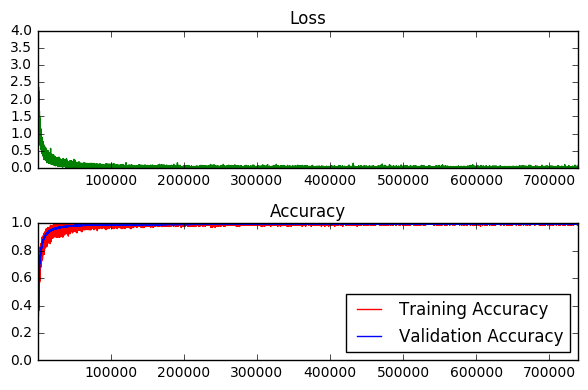

Validation accuracy at 0.9943022131919861
Test accuracy at 0.9698343276977539


In [39]:
### Train your model here.
### Feel free to use as many code cells as needed.
epochs = 1000
batch_size = 128

validation_accuracy = 0.0 # The accuracy measured against the validation set
test_accuracy = 0.0 # The accuracy measured against the validation set

# Measurements use for graphing loss and accuracy
log_batch_step = 10
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

# Here we go!
session=tf.Session()
session.run(init)
batch_count = int(math.ceil(len(X_train)/batch_size))

for epoch_i in range(epochs):
        
    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        batch_features = X_train[batch_start:batch_start + batch_size]
        batch_labels = y_train[batch_start:batch_start + batch_size]

        # Run optimizer and get loss
        _, l = session.run(
            [optimizer, loss],
            feed_dict={x_image: batch_features, y_true: batch_labels,keep_prob: 0.5})

        # Log every so many batches
        if not batch_i % log_batch_step:
            # Calculate Training and Validation accuracy                
            training_accuracy = session.run(accuracy,
                                            feed_dict={x_image: batch_features, 
                                                       y_true: batch_labels,
                                                       keep_prob: 0.5})
            validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)
                
    # Check accuracy against Validation data
    validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
    print('Validation accuracy at {}'.format(validation_accuracy))
                
    # Save the variables to disk.
    save_path = saver.save(session, "./models/CNN_2layer_traffic_signs_01.ckpt")
    print("Model saved in file: %s" % save_path)
        
test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))
print('Test accuracy at {}'.format(test_accuracy))

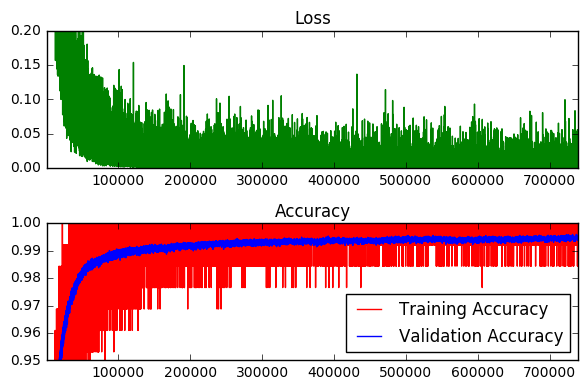

Validation accuracy at 0.9943022131919861
Test accuracy at 0.9698343276977539


In [44]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
loss_plot.set_ylim([0, 0.2])

acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0.95, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))
print('Test accuracy at {}'.format(test_accuracy))
session.close()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** The model was initially trained using stochastic gradient descent (SGD). Later SGD was swapped for the Adam Optimizer. No striking difference between the two optimizers was noticed during the initial training stages. The batch size was varied using just one epoch with the folloing batch size numbers (64,128,256). An acceptable compromise between speed and accuracy was found for a batch size of 128. Without regularization the architecture overfit quickly, but not too severly. Validation accuracy improved with the number of epochs increased monotonously for 1,100,500 and 1000 epochs. Presumably more training could still improve the results further. More exhaustive hyper parameter tuning would have been desirable, but was not feasible on a single GTX 1080 under the given time constraints.

Final result: the final test accuracy is 96.98% which is good but could certainly still be improved by more extensive hyper parameter tuning.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** In order to reduce overfitting dropout regularization was implemented on the first fully connected layer. The keep probability was set to 0.5. This improved the test results and the validation and training accuracies no longer deviated very much. It can be seen in the graph above that training accuracy has a variance of about 1%. At the present stage training the model for 1000 epochs takes several hours and it is is not feasible to do exhaustive hyperparameter tuning. No other regularization procedures were implemented for this reason.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

['13extra.jpg', '27extra.jpg', '25extra.jpg', '17extra.jpg', '15extra.jpg', '25bextra.jpg', '37extra.jpg', '33extra.jpg', '36extra.jpg', '39extra.jpg']


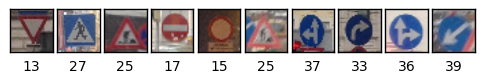

In [54]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import glob
import cv2

extra_images = glob.glob('*extra.jpg')
print(extra_images)
n_imgs = len(extra_images)

shape=(n_imgs,32,32,3);
X_extra = np.zeros(shape,dtype='uint8')


def square_crop_image(image):
    n=min(image.shape[:2])
    crop = cv2.resize(image[:n,:n],(32,32), interpolation = cv2.INTER_CUBIC)    
    return crop

# true class vector
y_extra = [int(y[:2]) for y in extra_images]

# generate the extra data set from the images taken
for img_name in extra_images:
    i = extra_images.index(img_name)
    img = plt.imread(img_name)
    img = square_crop_image(img)    
    #plt.figure()
    #plt.imshow(img)
    X_extra[i]=img

plot_images(X_extra[:10],n_imgs=10, cls_true = y_extra[:10])


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** I took 10 pictures of traffic signs myself using a mobile phone, see above.
The following shots are particularly interesting.

1. no vehicles sign at night time
2. no entry sign taken out the side window of a moving bus.
3. road road work sign, taken through the front window of a fast moving bus.
4. the Austrian variation of the pedestrians sign (not in the training set)
5. stay left sign taken from a moving bus.

Some are close ups, others from a distance of about 100 meters, most through the front window of a moving bus, but some also through the side windows which led to perspective distortions and greater motion blur. One was taken at night time. The traffic signs where manually extracted, interpolated and preprocessed like the training set to fit the (32,32,1) input shape of the neural network trained above. In the present case the distortions are due to motion blur, bad contrast and perspective distortions.  Particularly interesting is the "pedestrians" sign shown below which does **not** occur in the training set in this form. The Austrian variation of this  traffic sign differs significantly from the German one. I have nevertheless indicated the correct class, class 27, below.

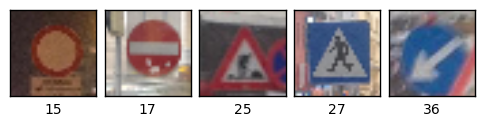

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(1,5)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
y_choose = np.array([15,17,25,27,36])
indices = [4,3,2,1,9]
X_choose  = X_extra[indices]

for i,ax in enumerate(axes.flat):    
    xlabel = "{0}".format(y_choose[i])
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(X_choose[i])


In [57]:
### We predict the classes of all 10 extra images using the previously trained CNN
y_extra_cls = y_extra
y_choose_cls = y_choose
X_extra_pp  = preprocess_images(X_extra)
X_extra_pp  = X_extra_pp.astype(np.float32)
X_choose_pp = preprocess_images(X_choose)
X_choose_pp = X_choose_pp.astype(np.float32)

y_extra     = encoder.transform(y_extra_cls)
y_extra     = y_extra.astype(np.float32)
y_choose    = encoder.transform(y_choose_cls)
y_choose    = y_choose.astype(np.float32)

In [52]:
# Here we go again!
session=tf.Session()
session.run(init)
saver.restore(session, './models/CNN_2layer_traffic_signs_01.ckpt')

In [58]:
extra_accuracy = 0.0
extra_feed_dict  = {x_image: X_extra_pp, y_true: y_extra,keep_prob: 1.0}
extra_accuracy = session.run(accuracy, feed_dict=extra_feed_dict)
print('Extra data set accuracy at {}'.format(extra_accuracy))

choose_accuracy = 0.0
choose_feed_dict  = {x_image: X_choose_pp, y_true: y_choose,keep_prob: 1.0}
choose_accuracy = session.run(accuracy, feed_dict=choose_feed_dict)
print('Choose data set accuracy at {}'.format(choose_accuracy))

Extra data set accuracy at 0.8999999761581421
Choose data set accuracy at 0.6000000238418579


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** For all traffic signs that also occur in the training set the predictions for the newly acquired images are correct here! The only exception is the Austrian "pedestrian" sign which did not get recognized. We will invetigate this case in more detail below.

In [59]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
#labels = tf.argmax(y_, 1)
#topFiver = tf.nn.in_top_k(y, labels, 5)
y_choose_predictions = session.run(tf.nn.top_k(y_pred,k=5), feed_dict=choose_feed_dict)
vals = y_choose_predictions.values
inds = y_choose_predictions.indices

In [60]:
vals.round(2)

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.97000003,  0.03      ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.85000002,  0.15000001,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ]], dtype=float32)

In [61]:
inds

array([[15,  8,  9,  7,  5],
       [17,  9, 14, 10, 38],
       [25, 11, 30, 20,  1],
       [18, 27, 26, 24, 25],
       [39, 20, 33, 25, 32]], dtype=int32)

Only two probabilities are significantly different from one. Together with the second highest probability they practically add up to one. We focus on these two cases and only on the two highest probabilities for this reason.  

(-0.1, 1.1)

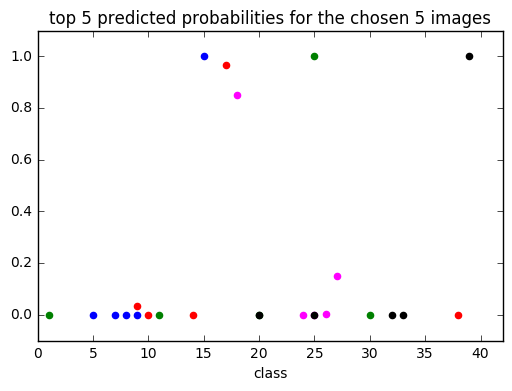

In [62]:
y0,y1,y2,y3,y4 = vals[0,:],vals[1,:],vals[2,:],vals[3,:],vals[4,:]
x0,x1,x2,x3,x4=inds[0,:],inds[1,:],inds[2,:],inds[3,:],inds[4,:]
plt.scatter(x0,y0,color="blue")
plt.scatter(x1,y1,color="red")
plt.scatter(x2,y2,color="green")
plt.scatter(x3,y3,color="magenta")
plt.scatter(x4,y4,color="black")
plt.title('top 5 predicted probabilities for the chosen 5 images')
plt.xlabel('class')
plt.xlim([0,42])
plt.ylim([-0.1,1.1])

All probability distributions are highly peaked around one value. The Austrian "Pedestrians" sign got wrongly classified. Below we show representatives of the signs with the two highest probabilities. The classes are 18 and 27 for the highest and second highest probabilities. 18 is the sign "General Caution", whereas 27 is the correct class "Pedestrians". A visual inspection makes clear how this misclassification comes about:

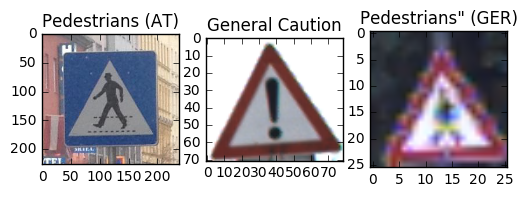

In [63]:
pedestrians_AT =mpimg.imread('27extra.jpg')
pedestrians_GER =mpimg.imread('00001.ppm')
caution=mpimg.imread('00008.ppm')

fig = plt.figure()
a=fig.add_subplot(1,3,1)
plt.imshow(pedestrians_AT)
a.set_title('Pedestrians (AT)')
a=fig.add_subplot(1,3,3)
plt.imshow(pedestrians_GER)
a.set_title('Pedestrians" (GER)')
a=fig.add_subplot(1,3,2)
plt.imshow(caution)
a.set_title('General Caution')


It is now interesting to find out whether the "Pedestrians" sign generally gets confused for the "Caution" sign. To do this we check the accuracy on these two signs and the respective probability distributions. 

In [92]:
sign_class_accuracy = []
for sign_class in range(n_classes):
    _ = np.array(y_test_cls).astype(np.uint8)
    class_indices = np.where(_==sign_class)
    X_class = X_test[class_indices]
    y_class = y_test[class_indices]

    class_accuracy = 0.0
    class_feed_dict  = {x_image: X_class, y_true: y_class,keep_prob: 1.0}
    class_accuracy = session.run(accuracy, feed_dict=class_feed_dict)
    sign_class_accuracy.append([sign_class,class_accuracy])
    #sign_class_accuracy[sign_class] = class_accuracy
    #print('sign class accuracy at {}'.format(class_accuracy))
sign_class_accuracy = np.array(sign_class_accuracy)


In [97]:
sign_class_accuracy[sign_class_accuracy[:,1]<0.90]

array([[  6.        ,   0.87333333],
       [ 18.        ,   0.89487189],
       [ 21.        ,   0.82222223],
       [ 26.        ,   0.84444451],
       [ 27.        ,   0.55000007],
       [ 30.        ,   0.75333333],
       [ 40.        ,   0.88888896]])

There are other traffic signs where the predictions are not accurate. The worst is the "Pedestrians" sign, class number 27, with an accuracy of only 55%, second is number 30 "Beware of ice, snow". Both occur rarely in the data set.

(-0.1, 1.1)

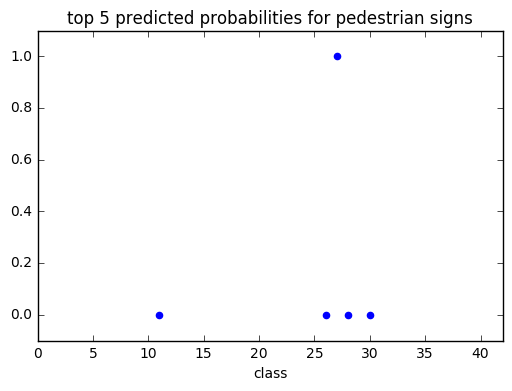

In [99]:
_ = np.array(y_test_cls).astype(np.uint8)
class_indices = np.where(_==27)
X_pedestrian = X_test[class_indices]
y_pedestrian = y_test[class_indices]

pedestrian_accuracy = 0.0
pedestrian_feed_dict  = {x_image: X_pedestrian, y_true: y_pedestrian,keep_prob: 1.0}
y_pedestrians_pred = session.run(tf.nn.top_k(y_pred,k=5), 
                         feed_dict=pedestrian_feed_dict)
vals = y_pedestrians_pred.values
inds = y_pedestrians_pred.indices

y0 = vals[0,:]
x0 = inds[0,:]
plt.scatter(x0,y0,color="blue")
plt.title('top 5 predicted probabilities for pedestrian signs')
plt.xlabel('class')
plt.xlim([0,42])
plt.ylim([-0.1,1.1])


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** The softmax probabilities are fairly certain for the given images and correct here. The Austrian pedestrian sign was classified as "General Caution". There is a large amount of similarity between the "General Caution" and the "Pedestrians" signs, which explains the (only) misclassification here. The general caution sign is predicted with a probability of 85%. The "Pedestrians sign still comes second with a 15% probability. It is surprising that given the correct general shape was predicted, the network decided to predict the "General Caution" sign instead of the correct "Pedestrians" sign. One reason might be that there are relatively few examples of the "Pedestrians class" in the original training set, 210, whereas there are 1200 of "General Caution",almost six times as many.


The subsequent analysis of the test set predictions showed that the "Pedestrians" sign is the worst classified sign of all in the test set. Unfortunately the network is very sure about its (wrong) predictions as can be seen from the graph shown above.  This is likely due to not balancing the training set equally over all classes, which biased the predictions. 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** Apart from the additional preprocessing functions that crop and resize a section of a provided image to fit the model architecture no automatic interface was built to classify newly acquired images. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.